In [1]:
# Do the imports
import matplotlib.pyplot as plt
%matplotlib inline
import http.client
from urllib.parse import urlencode, quote
import time
import datetime
from hashlib import sha1
import random
import string
import os
import sys
import urllib as ul
import json
import numpy as np
import seaborn as sns
import numpy as np
import pandas as pd
#from geopy.geocoders import Nominatim
from IPython.core.display import display, HTML, Image
Image(url='https://bcdn.se/images/resources/booli_logo.png')

In [2]:
#Set style
#plt.style.use('fivethirtyeight')

plt.rc('grid', linestyle="--",alpha = 0.8)
plt.rc('font', size=14, family='sans-serif',style='normal',weight='normal')
plt.rc('legend', frameon=False,fontsize=14)
plt.rc('axes', labelsize=16, titlesize=20)
plt.rc('figure', figsize=(16,8),titlesize=20,facecolor ='white')
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('lines', linewidth=3)
plt.rcParams['axes.formatter.limits'] = (-4,4)

In [4]:

district =      ['Stockholm innerstad']
#district =      ['Tegefjäll']
#district =      ['Östersund']
#district =      ['Sverige']
#district =      ['Åre', 'Östersund']
#district =      ['Stockholm innerstad']
startDate =     '2020-01-01'
endDate =       datetime.datetime.now().strftime('%Y-%m-%d')
callerId =      'hjartarson'
privateKey =    'wKalNs1fMuymxyXtN9wPwEypXpwtVWA3JT4uepf8'
#minLivingArea = 50
#maxLivingArea = 70

In [5]:
# Must have Booli authentification 
timestamp = str(int(time.time()))
unique = ''.join(random.choice(string.ascii_uppercase + string.digits) for x in range(16))
hashstr = sha1((callerId+timestamp+privateKey+unique).encode('utf-8')).hexdigest()

In [6]:

connection = http.client.HTTPConnection("api.booli.se")
result = []
limit = 1000
for dist in district:
    print('Collect data for: ', dist)
    MO = True
    objects = 0
    offset = 0
    while MO==True:
        print('limit:', limit, 'offset: ',offset)
        url = ("/sold?q="+quote(dist)+"&"
               "minSoldDate="+startDate+"&"
               "maxSoldDate="+endDate+"&"
               #"minLivingArea="+str(minLivingArea)+"&"
               #"maxLivingArea="+str(maxLivingArea)+"&"
               "limit="+str(limit)+"&"+
               "offset="+str(offset)+"&"
               "callerId="+callerId+"&time="+timestamp+"&unique="+unique+"&hash="+hashstr)
        connection.request("GET", url)
        response = connection.getresponse()
        if response.status != 200:
            print("fail")
        else:
            data = response.read().decode('utf8')
            result.append(json.loads(data))
            print('objects added:', result[-1]['count'])
        objects = objects + limit
        if objects > result[-1]['totalCount']:
            MO=False
            print('all objects added: ',len(result), ', totalCount: ',result[-1]['totalCount'])
        else:
            print('adjusting offset')
            offset = offset + limit
            time.sleep(0.2)
connection.close()

Collect data for:  Stockholm innerstad
limit: 1000 offset:  0
objects added: 1000
adjusting offset
limit: 1000 offset:  1000
objects added: 1000
adjusting offset
limit: 1000 offset:  2000
objects added: 1000
adjusting offset
limit: 1000 offset:  3000
objects added: 1000
adjusting offset
limit: 1000 offset:  4000
objects added: 1000
adjusting offset
limit: 1000 offset:  5000
objects added: 1000
adjusting offset
limit: 1000 offset:  6000
objects added: 1000
adjusting offset
limit: 1000 offset:  7000
objects added: 1000
adjusting offset
limit: 1000 offset:  8000
objects added: 1000
adjusting offset
limit: 1000 offset:  9000
objects added: 1000
adjusting offset
limit: 1000 offset:  10000
objects added: 1000
adjusting offset
limit: 1000 offset:  11000
objects added: 1000
adjusting offset
limit: 1000 offset:  12000
objects added: 1000
adjusting offset
limit: 1000 offset:  13000
objects added: 1000
adjusting offset
limit: 1000 offset:  14000
objects added: 1000
adjusting offset
limit: 1000 of

In [7]:

# Merge all data into one dataframe
df = pd.DataFrame()
for res in result:
    df1 = pd.DataFrame(res['sold'])
    df = df.append(df1)
df = df.set_index('booliId',drop=False)
df_copy = df.copy()
df.info()
print('\nBooliId is an unique index:',df.index.is_unique)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32287 entries, 4667804 to 3681854
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source             32287 non-null  object 
 1   rooms              32226 non-null  float64
 2   constructionYear   29450 non-null  float64
 3   soldDate           32287 non-null  object 
 4   location           32287 non-null  object 
 5   rent               32112 non-null  float64
 6   livingArea         32258 non-null  float64
 7   soldPriceSource    32287 non-null  object 
 8   listPrice          29744 non-null  float64
 9   soldPrice          32287 non-null  int64  
 10  booliId            32287 non-null  int64  
 11  floor              30209 non-null  float64
 12  objectType         32287 non-null  object 
 13  published          31828 non-null  object 
 14  url                32287 non-null  object 
 15  additionalArea     16779 non-null  float64
 16  apartmentNumbe

In [8]:
df['soldDate'] = pd.to_datetime(df['soldDate'])
df['soldPriceSqm'] = df['soldPrice'].div(df['livingArea'])
df.loc[:,'soldMonth'] = df.loc[:,'soldDate'].dt.to_period('M')
df.loc[:,'soldPriceSqm'] = df.loc[:,'soldPrice']/df.loc[:,'livingArea']
df.loc[:,'listPriceSqm'] = df.loc[:,'listPrice']/df.loc[:,'livingArea']

#df.to_pickle('osd.pkl')

In [9]:
df.groupby(['objectType'])['objectType'].count()

objectType
Fritidshus        1
Gård              1
Lägenhet      32264
Radhus           13
Villa             8
Name: objectType, dtype: int64

In [10]:
df['week'] = df['soldDate'].dt.isocalendar().week
df['year'] = df['soldDate'].dt.year
df['dayofweek'] = df['soldDate'].dt.dayofweek
df['livingAreaBin'] = df['livingArea'].div(10).round(0).mul(10)

In [11]:
df.head(1).T

booliId,4667804
source,"{'id': 313076855, 'url': 'https://aliciaedelma..."
rooms,3
constructionYear,1939
soldDate,2022-08-23 00:00:00
location,"{'position': {'latitude': 59.34912, 'longitude..."
rent,2931
livingArea,53
soldPriceSource,maklare
listPrice,5.495e+06
soldPrice,5495000


<AxesSubplot:xlabel='livingAreaBin'>

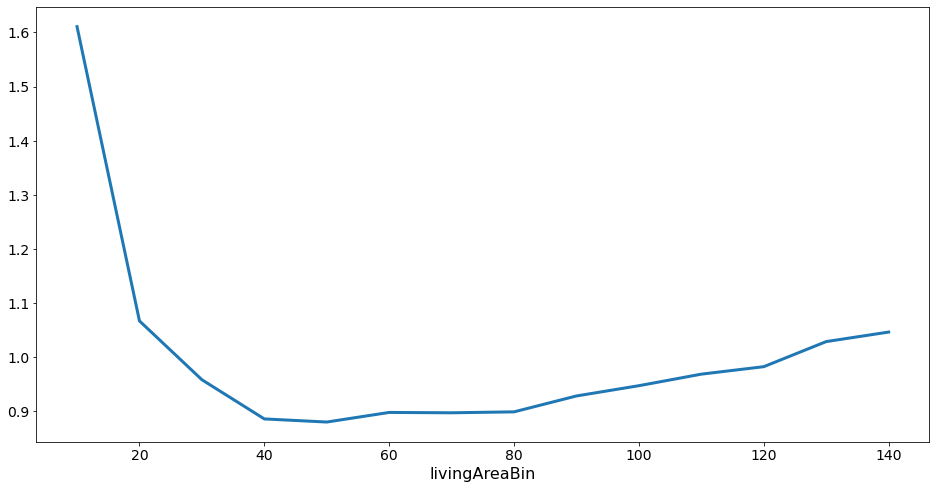

In [12]:
df_living = df[df['livingAreaBin']<150].groupby(['livingAreaBin'])['soldPriceSqm'].mean().rename('livingAreaScale')
df_living = df_living.div(df_living.mean())
df_living.plot()

soldDate
2022-08-20    103.142286
2022-08-21    103.487436
2022-08-22    103.435624
2022-08-23    102.918143
2022-08-24    102.773529
2022-08-25    101.954880
2022-08-26    102.541068
2022-08-27    104.616944
2022-08-28    104.532053
2022-08-29    104.759388
Name: soldPriceSqm, dtype: float64
soldDate
2022-08-20    24.285714
2022-08-21    24.142857
2022-08-22    24.714286
2022-08-23    26.000000
2022-08-24    26.000000
2022-08-25    26.142857
2022-08-26    25.857143
2022-08-27    27.000000
2022-08-28    26.857143
2022-08-29    24.142857
Name: soldPriceSqm, dtype: float64


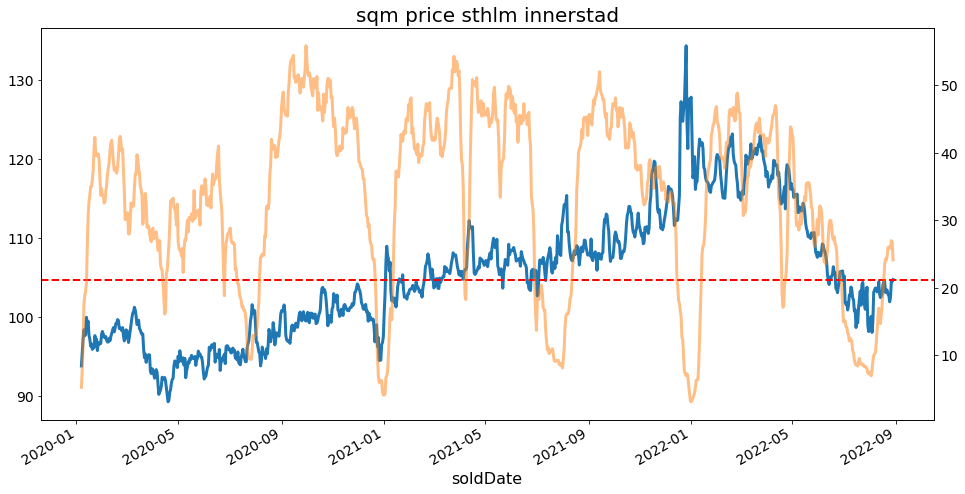

In [13]:
days = 7

df_cell = df[(df['objectType']=='Lägenhet') & (df['soldDate']>'2016-01-01')].groupby(['soldDate'])['soldPriceSqm'].mean().mul(1e-3).rolling(days).mean()#.iloc[:-1]
#df_cell = df_cell.div(df_cell.loc['2021-07-20'])
ax = df_cell.plot(title='sqm price sthlm innerstad')
ax.axhline(df_cell.iloc[-1], ls='--', lw=2, c='r')
#ax.axhline(120, ls='--', lw=2, c='r')
print(df_cell.tail(10))
df_cell = df[(df['objectType']=='Lägenhet') & (df['soldDate']>'2016-01-01')].groupby(['soldDate'])['soldPriceSqm'].count().rolling(days).mean()#.iloc[:-1]
ax = df_cell.plot(secondary_y = True, alpha = 0.5)
print(df_cell.tail(10))

In [ ]:
df.groupby(['soldDate'])['soldPriceSqm'].count().plot()

#[(df['soldDate']>'2021-06-01') & (df['soldDate']<'2021-10-01')]

In [ ]:
df.head()

In [64]:
import numpy as np
vec=['red','other']
P=[0.25,0.75]
idx = np.arange(200000)
df = pd.DataFrame(index = idx, columns=vec)

for i in idx:
    a = np.random.choice(vec,size=1000,replace=True, p=P)
    unique, counts = np.unique(a, return_counts=True)
    df.loc[i, unique] = counts
    if i%10000==0:
        print(i)
    
df

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000


,red,other
0,286,714
1,264,736
2,243,757
3,257,743
4,233,767
...,...,...
199995,265,735
199996,250,750
199997,267,733
199998,240,760


In [65]:
df['red'].mean(), df['red'].std()

(249.99461, 13.663431647822666)

In [35]:
columns = ['source','rooms', 'constructionYear', 'soldDate',
       'livingArea', 'listPrice', 'soldPrice','apartmentNumber', 'plotArea', 'isNewConstruction', 'soldPriceSqm']
df[(df['objectType']=='Lägenhet') & (df['soldDate']=='2022-06-15')].sort_values(by='soldPriceSqm').iloc[8]

source               {'id': 1561, 'url': 'https://www.bjurfors.se/'...
rooms                                                                2
constructionYear                                                  1905
soldDate                                           2022-06-15 00:00:00
location             {'position': {'latitude': 59.31093, 'longitude...
rent                                                              3010
livingArea                                                          59
soldPriceSource                                                  bobot
listPrice                                                     5.75e+06
soldPrice                                                      5900000
booliId                                                        4670065
floor                                                                4
objectType                                                    Lägenhet
published                                          2022-06-04 10:06:14
url   

<AxesSubplot:xlabel='week,dayofweek'>

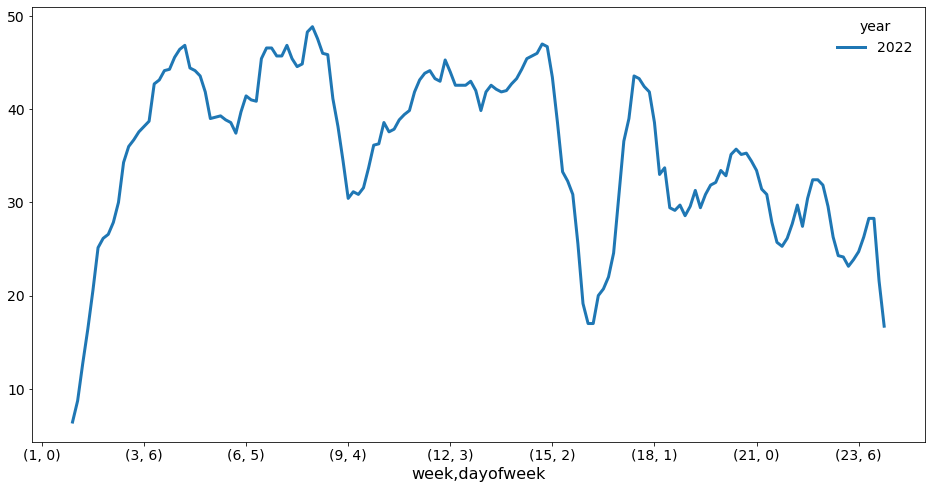

In [55]:
df.groupby(['year', 'week', 'dayofweek'])['soldPriceSqm'].count().unstack(level=0).rolling(7).mean().plot()

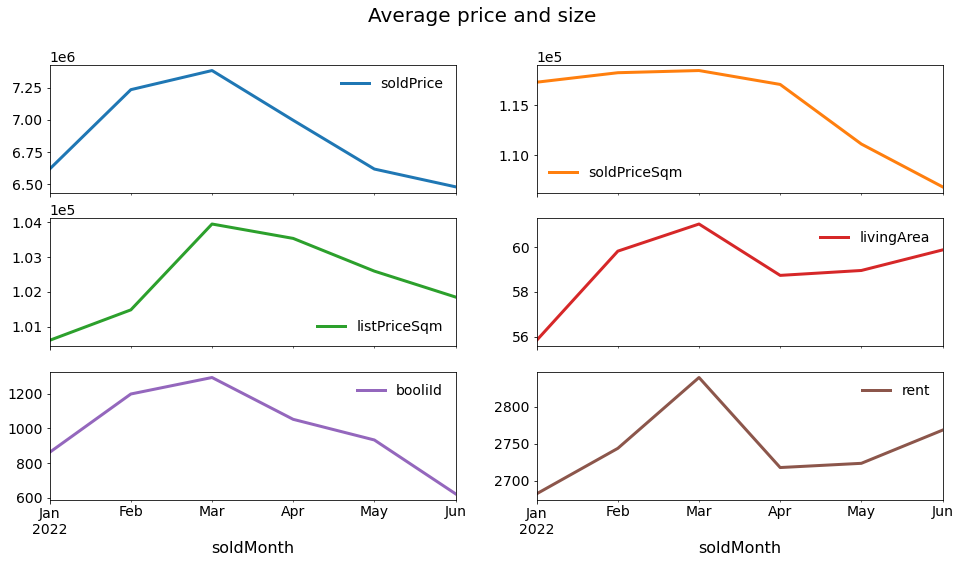

In [62]:
df_cell = df[(df['objectType']=='Lägenhet')]

f, ax = plt.subplots(3,2,sharex = True)
agg = {'soldPrice':'mean',
       'soldPriceSqm':'mean',
       'listPriceSqm':'mean',
       'livingArea':'mean',
       'booliId':'count',
       'rent':'mean'}
df_cell[(df_cell['soldDate']<'2022-06-24')].groupby('soldMonth').agg(agg).plot(ax=ax, kind='line',title='Average price and size',subplots=True)
plt.show()

In [91]:
df['year'] = df['soldDate'].dt.year
df['dayofyear'] = df['soldDate'].dt.dayofyear

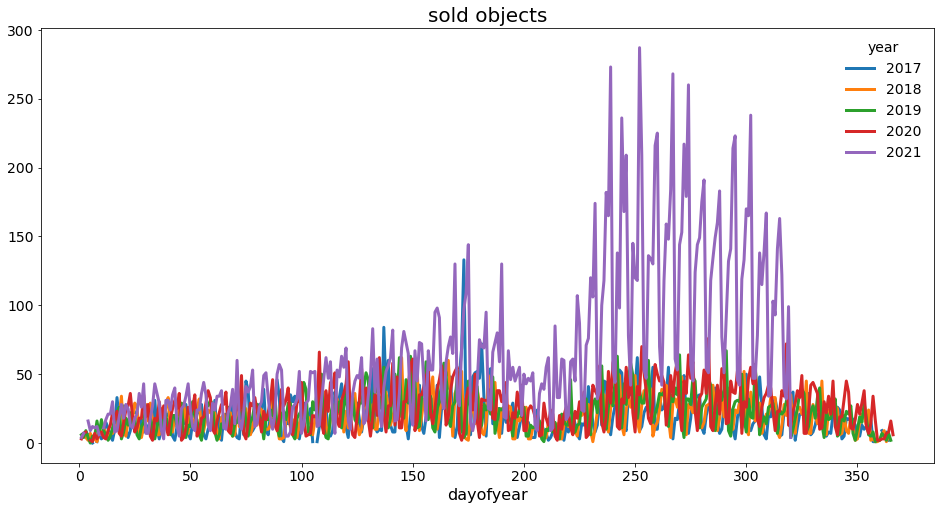

In [94]:

ax = df[(df['objectType']=='Lägenhet')].groupby(['year', 'dayofyear'])['soldPriceSqm'].count().rolling(1).mean().unstack(level=0).plot(title='sold objects')

#df[(df['objectType']=='Villa')].groupby(['year', 'dayofyear'])['soldPriceSqm'].mean().rolling(14).mean().unstack(level=0).plot(title='sold objects', ax=ax)

In [65]:
df.groupby('objectType', dropna=False).count().max(axis=1ö
                                                   -ö
                                                   -+pöö'p-
                                                   

objectType
Fritidshus     14058
Gård            4275
Hus                2
Kedjehus        3565
Lägenhet      410492
Parhus          4177
Radhus         17960
Tomt/Mark       5380
Villa          52944
Övrigt             6
dtype: int64

<AxesSubplot:title={'center':'sqm price'}, xlabel='dayofyear'>

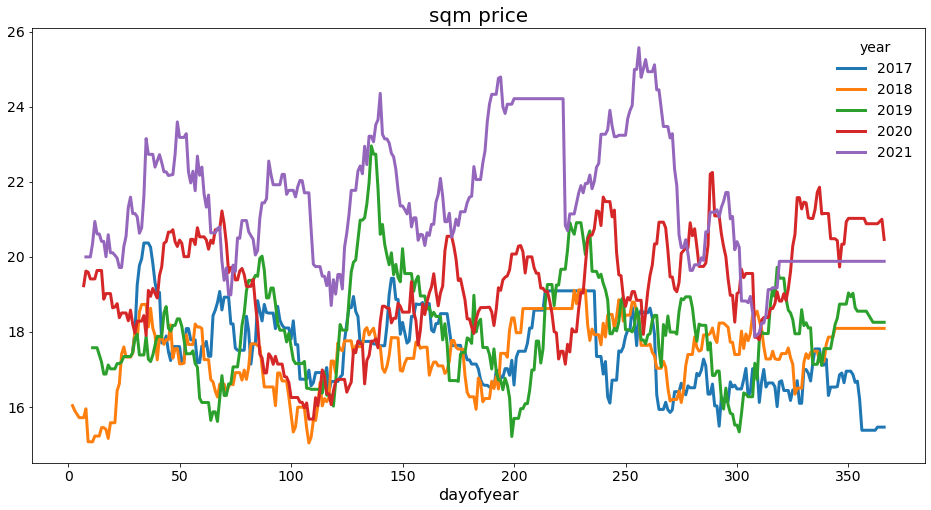

In [80]:
df_cell.groupby(['year', 'dayofyear'])['soldPriceSqm'].median().rolling(14).mean().mul(1e-3).unstack(level=0).ffill().plot(title='sqm price')